In [1]:
import time
import math
import numpy as np
from problems import sixth_order
from pinn import SP_PINN, make_points
from plots_and_stats import plot_errors, plot_comparison
np.random.seed(1234)

a1 = 1.000, a2 = -1.000, a3 = -2.800, a4 = -0.300, a5 = -0.600, a6 = 0.100,
 b1 = 6.000, b2 = -1.525, b3 = 0.113


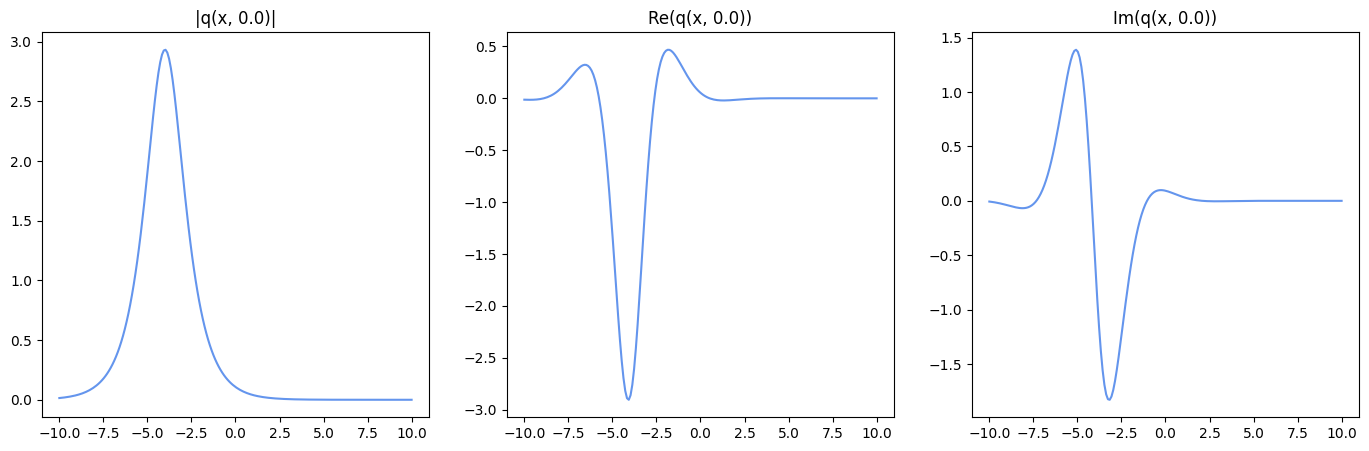

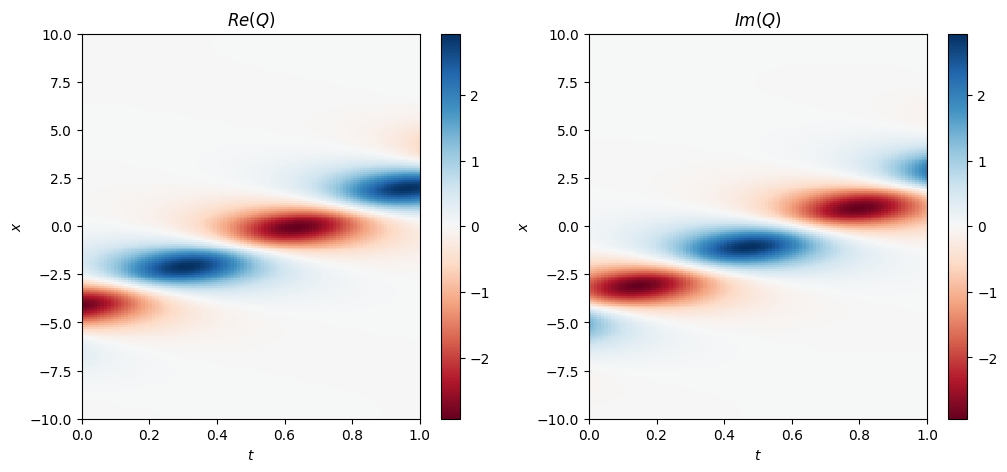

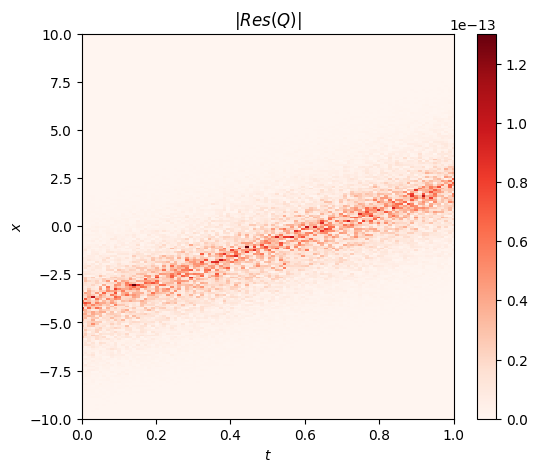

In [2]:
#domain setting
x_0=-10.
x_1=10.
t_0=0.
t_1=1.
#problem setting
a1 = 1
a2 = -1
a4 = -0.3
a6 = 0.1
b1 = 6
khi = 1
a_param = 0.5
x0_param = 4
theta0 = math.pi/3
problem = sixth_order(x_0, x_1, t_0, t_1, a1, a2, a4, a6, b1, khi, a_param, x0_param, theta0)
#info about the problem
problem.show_params()
problem.show_ic(x_resolution=200)
problem.show_solution(x_resolution=200, t_resolution=100, show_residual=True)

In [3]:
#data for training
X_i_train, U_i_train, V_i_train, X_b_train, X_grid = make_points(problem, init_points_amt=400, bound_points_amt=100, grid_resolution_x=200, grid_resolution_t=100)
#data for metrics evaluation
x_parts=200
t_parts=100
x=np.linspace(x_0,x_1,x_parts)
t=np.linspace(t_0,t_1,t_parts)
X, T = np.meshgrid(x, t)
X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None])) #test input for PINN
Q_truth=problem.q(X,T) #ground truth
x_layers = [1, 30, 30] #x network topology
t_layers = [1, 30, 30, 30] #t network topology

In [4]:
%%time
model = SP_PINN(problem, x_layers, t_layers, X_i_train, U_i_train, V_i_train, X_b_train, X_grid)
##Setting hyperparameters
#verbosity
model.verbosity = 1000 #loss output frequency
model.make_res_gif = False #makes gif with residual history
#points generation options
model.points_gen_method = "second" #"random"/first"/"second"/"third"
model.points_gen_freq = 10 #points generation frequency
model.points_am = 10000 #amount of collocation points
#optimization options
model.adam_steps = 10000
model.lbfgs_steps = 0
model.nncg_steps = 0
model.adam_step_decay = 0.9985
model.lbfgs_step_decay = 0.990
model.nncg_step_decay = 0.990
model.decay_freq = 100
#loss balancing options
model.loss_bal_method = "none" #"none"/"relobralo"
model.bal_freq = 1000 #loss rebalancing frequency
model.lambda_i = 950/1000
model.lambda_b = 49/1000
model.lambda_f = 1/1000
model.extinction = 0.37 #extinction coefficient for ReLoBRaLo
#causal training
model.causal_loss = False
model.epsilon = 0.79
model.t_partition = 50 #number of parts in the [t_0, t_1] division

model.train()

Training started with second points generation method and none loss balancing
10000 steps of ADAM:
Iter 1000, Loss: 2.747e-03, Loss_i: 2.04e-03, Loss_b: 1.65e-03, Loss_f: 7.31e-01
Iter 2000, Loss: 1.404e-03, Loss_i: 8.78e-04, Loss_b: 8.33e-04, Loss_f: 5.30e-01
Iter 3000, Loss: 9.997e-04, Loss_i: 6.22e-04, Loss_b: 6.69e-04, Loss_f: 3.76e-01
Iter 4000, Loss: 1.854e-03, Loss_i: 1.43e-03, Loss_b: 1.13e-03, Loss_f: 4.37e-01
Iter 5000, Loss: 8.233e-04, Loss_i: 4.76e-04, Loss_b: 2.18e-04, Loss_f: 3.61e-01
Iter 6000, Loss: 1.072e-03, Loss_i: 5.59e-04, Loss_b: 5.50e-04, Loss_f: 5.14e-01
Iter 7000, Loss: 5.589e-04, Loss_i: 2.59e-04, Loss_b: 1.58e-04, Loss_f: 3.05e-01
Iter 8000, Loss: 4.544e-04, Loss_i: 2.10e-04, Loss_b: 1.22e-04, Loss_f: 2.49e-01
Iter 9000, Loss: 4.720e-04, Loss_i: 2.09e-04, Loss_b: 1.25e-04, Loss_f: 2.68e-01
Iter 10000, Loss: 4.074e-04, Loss_i: 1.69e-04, Loss_b: 1.29e-04, Loss_f: 2.41e-01
Total iterations: 10000 + 0 + 0
CPU times: user 1h 30min 30s, sys: 5min 57s, total: 1h 36m

In [5]:
import torch
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
torch.save(model, f'model(6th_order).pth')
#model = torch.load(f'model(6th_order).pth', map_location=device)

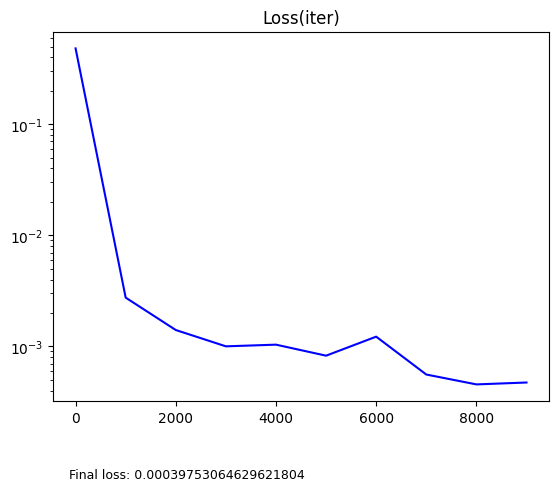

In [6]:
model.train_hist(logscale=True, step=1000)

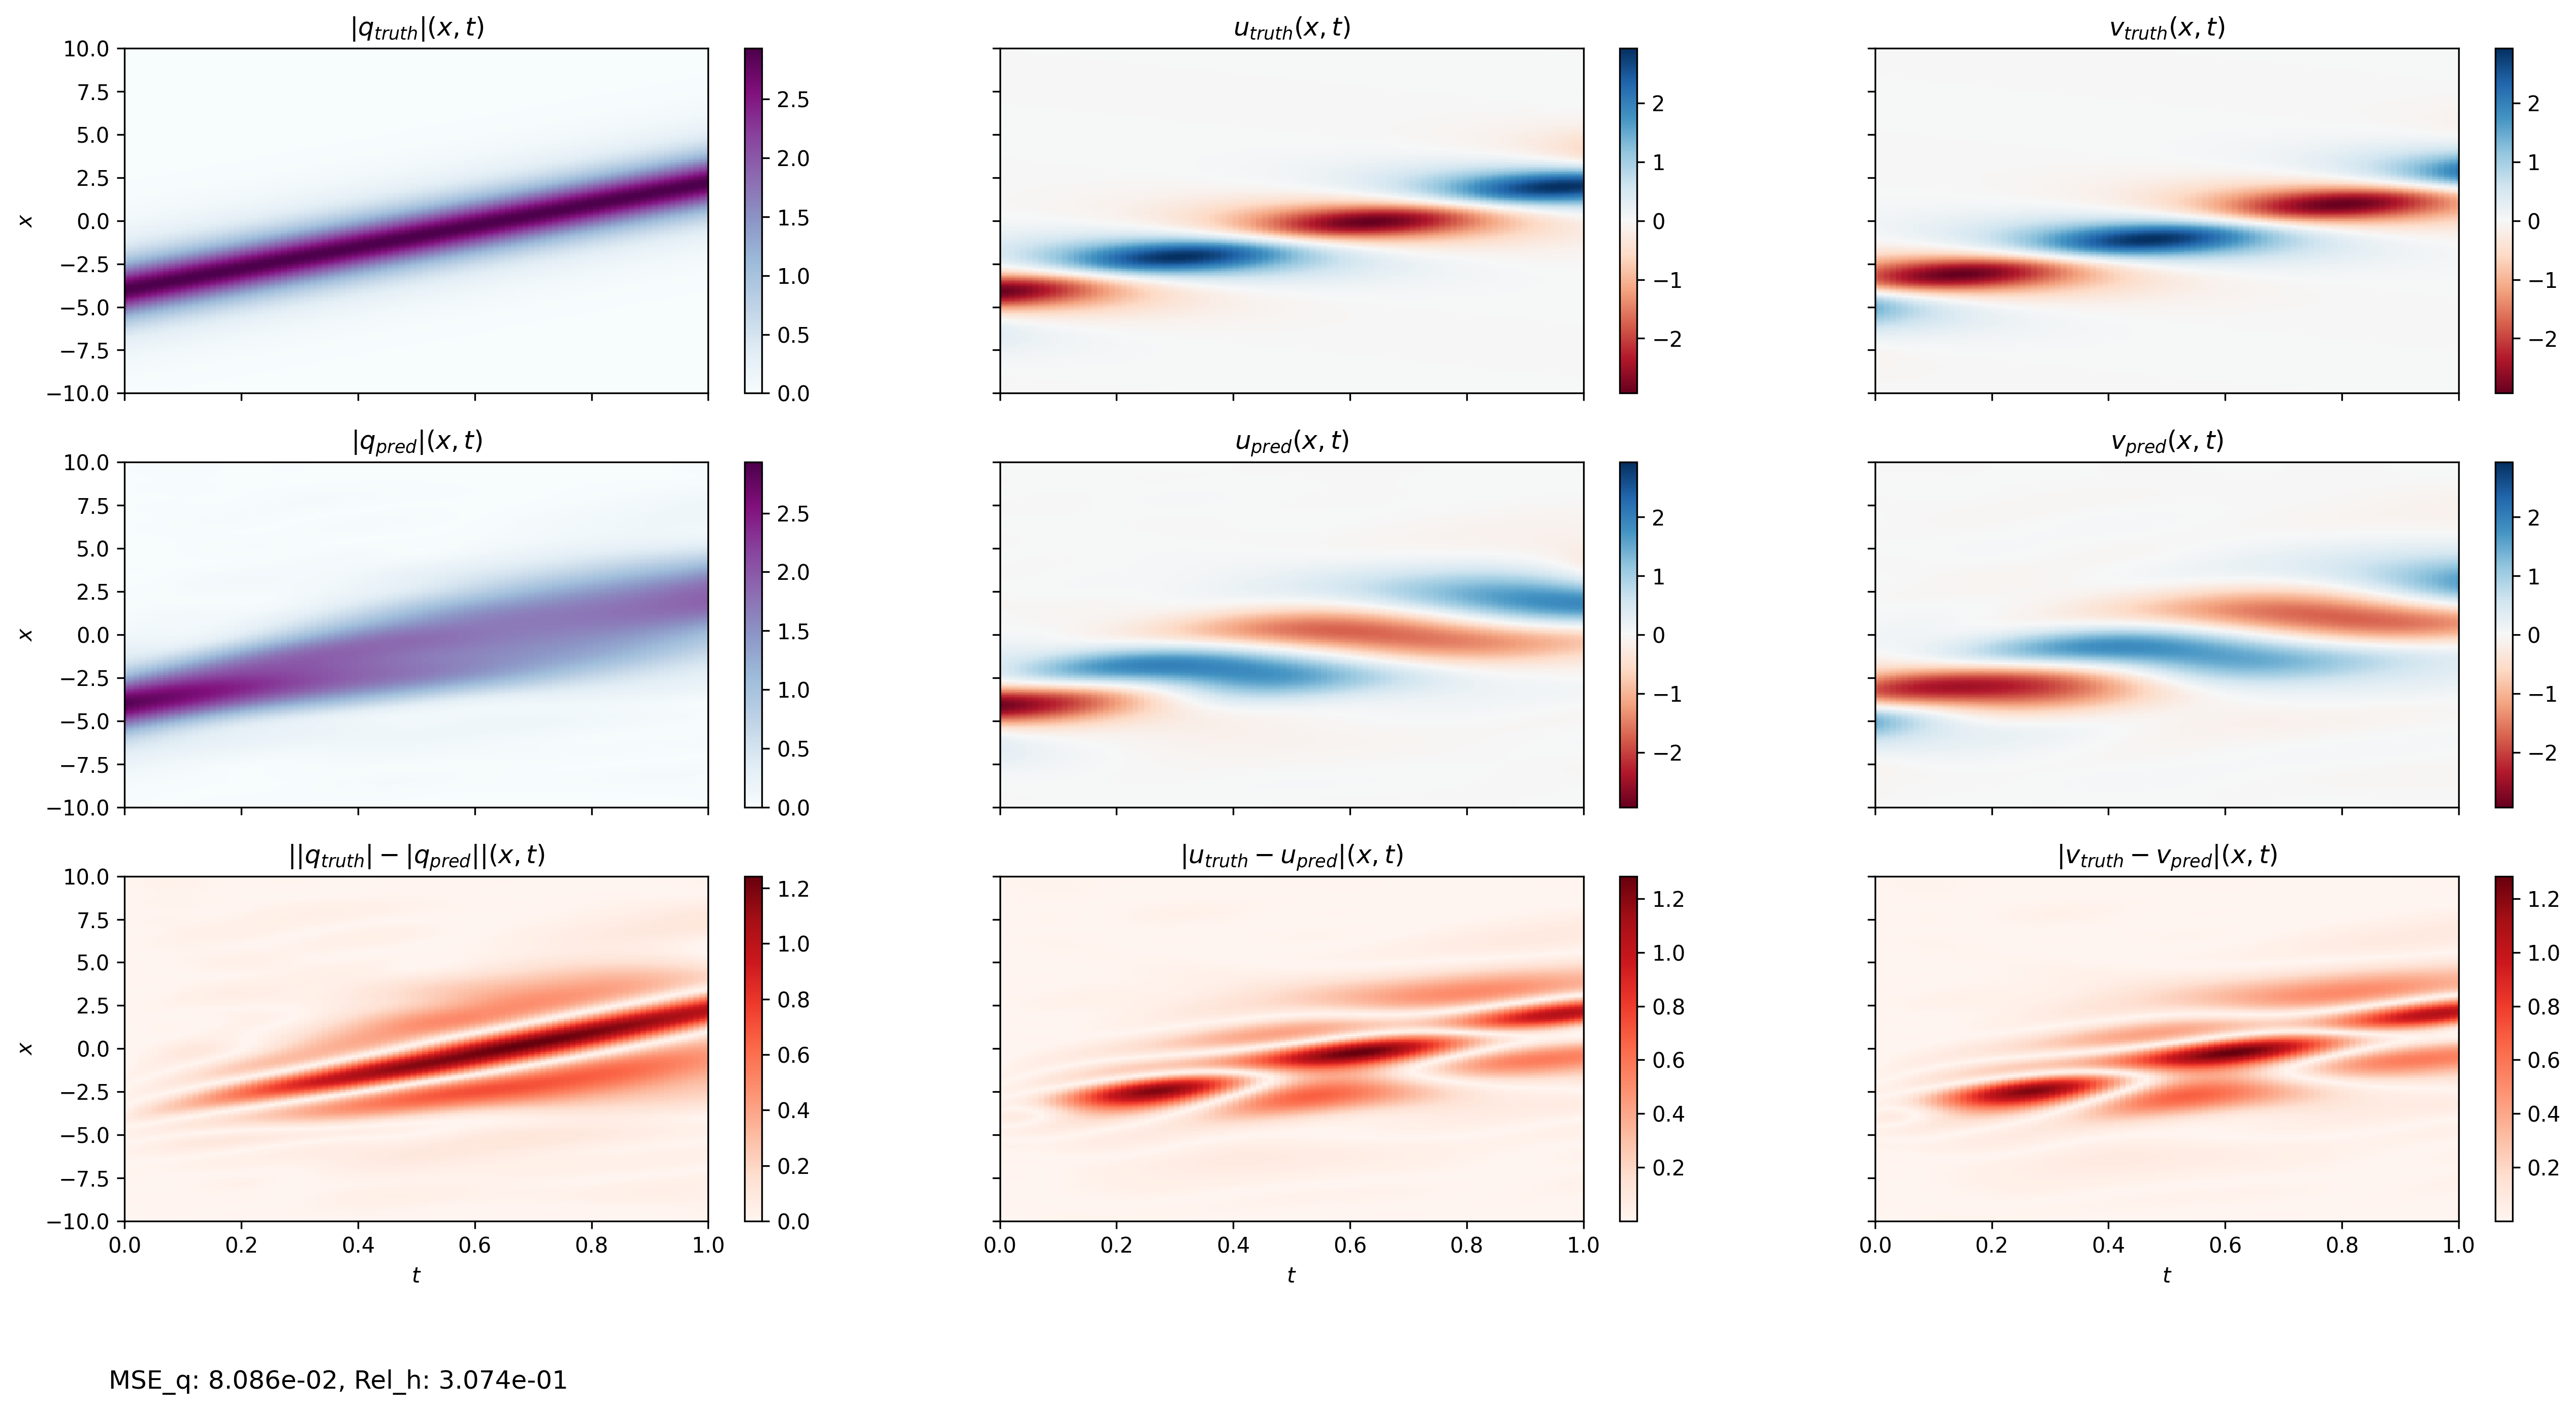

{'MSE_q': 0.08086189920871233, 'Rel_h': 0.3074052694911164}

In [7]:
u_pred, v_pred, f_u_pred, f_v_pred = model.predict(X_star)
Q_pred=u_pred.reshape((t_parts, x_parts)) + 1j*v_pred.reshape((t_parts, x_parts))
plot_comparison(X, T, Q_pred, Q_truth, savefig=True, namefig="test_comparison(6th_order).png")

Dimensionality by x: 200, by t: 100


{'Lw1_per_max': 27.560738710473814,
 'Lw1_per_mean': 19.59898737254358,
 'Lw2_per_max': 31.4479755533377,
 'Lw2_per_mean': 22.408741682130383,
 'Rel_h': 0.3074052694911164}

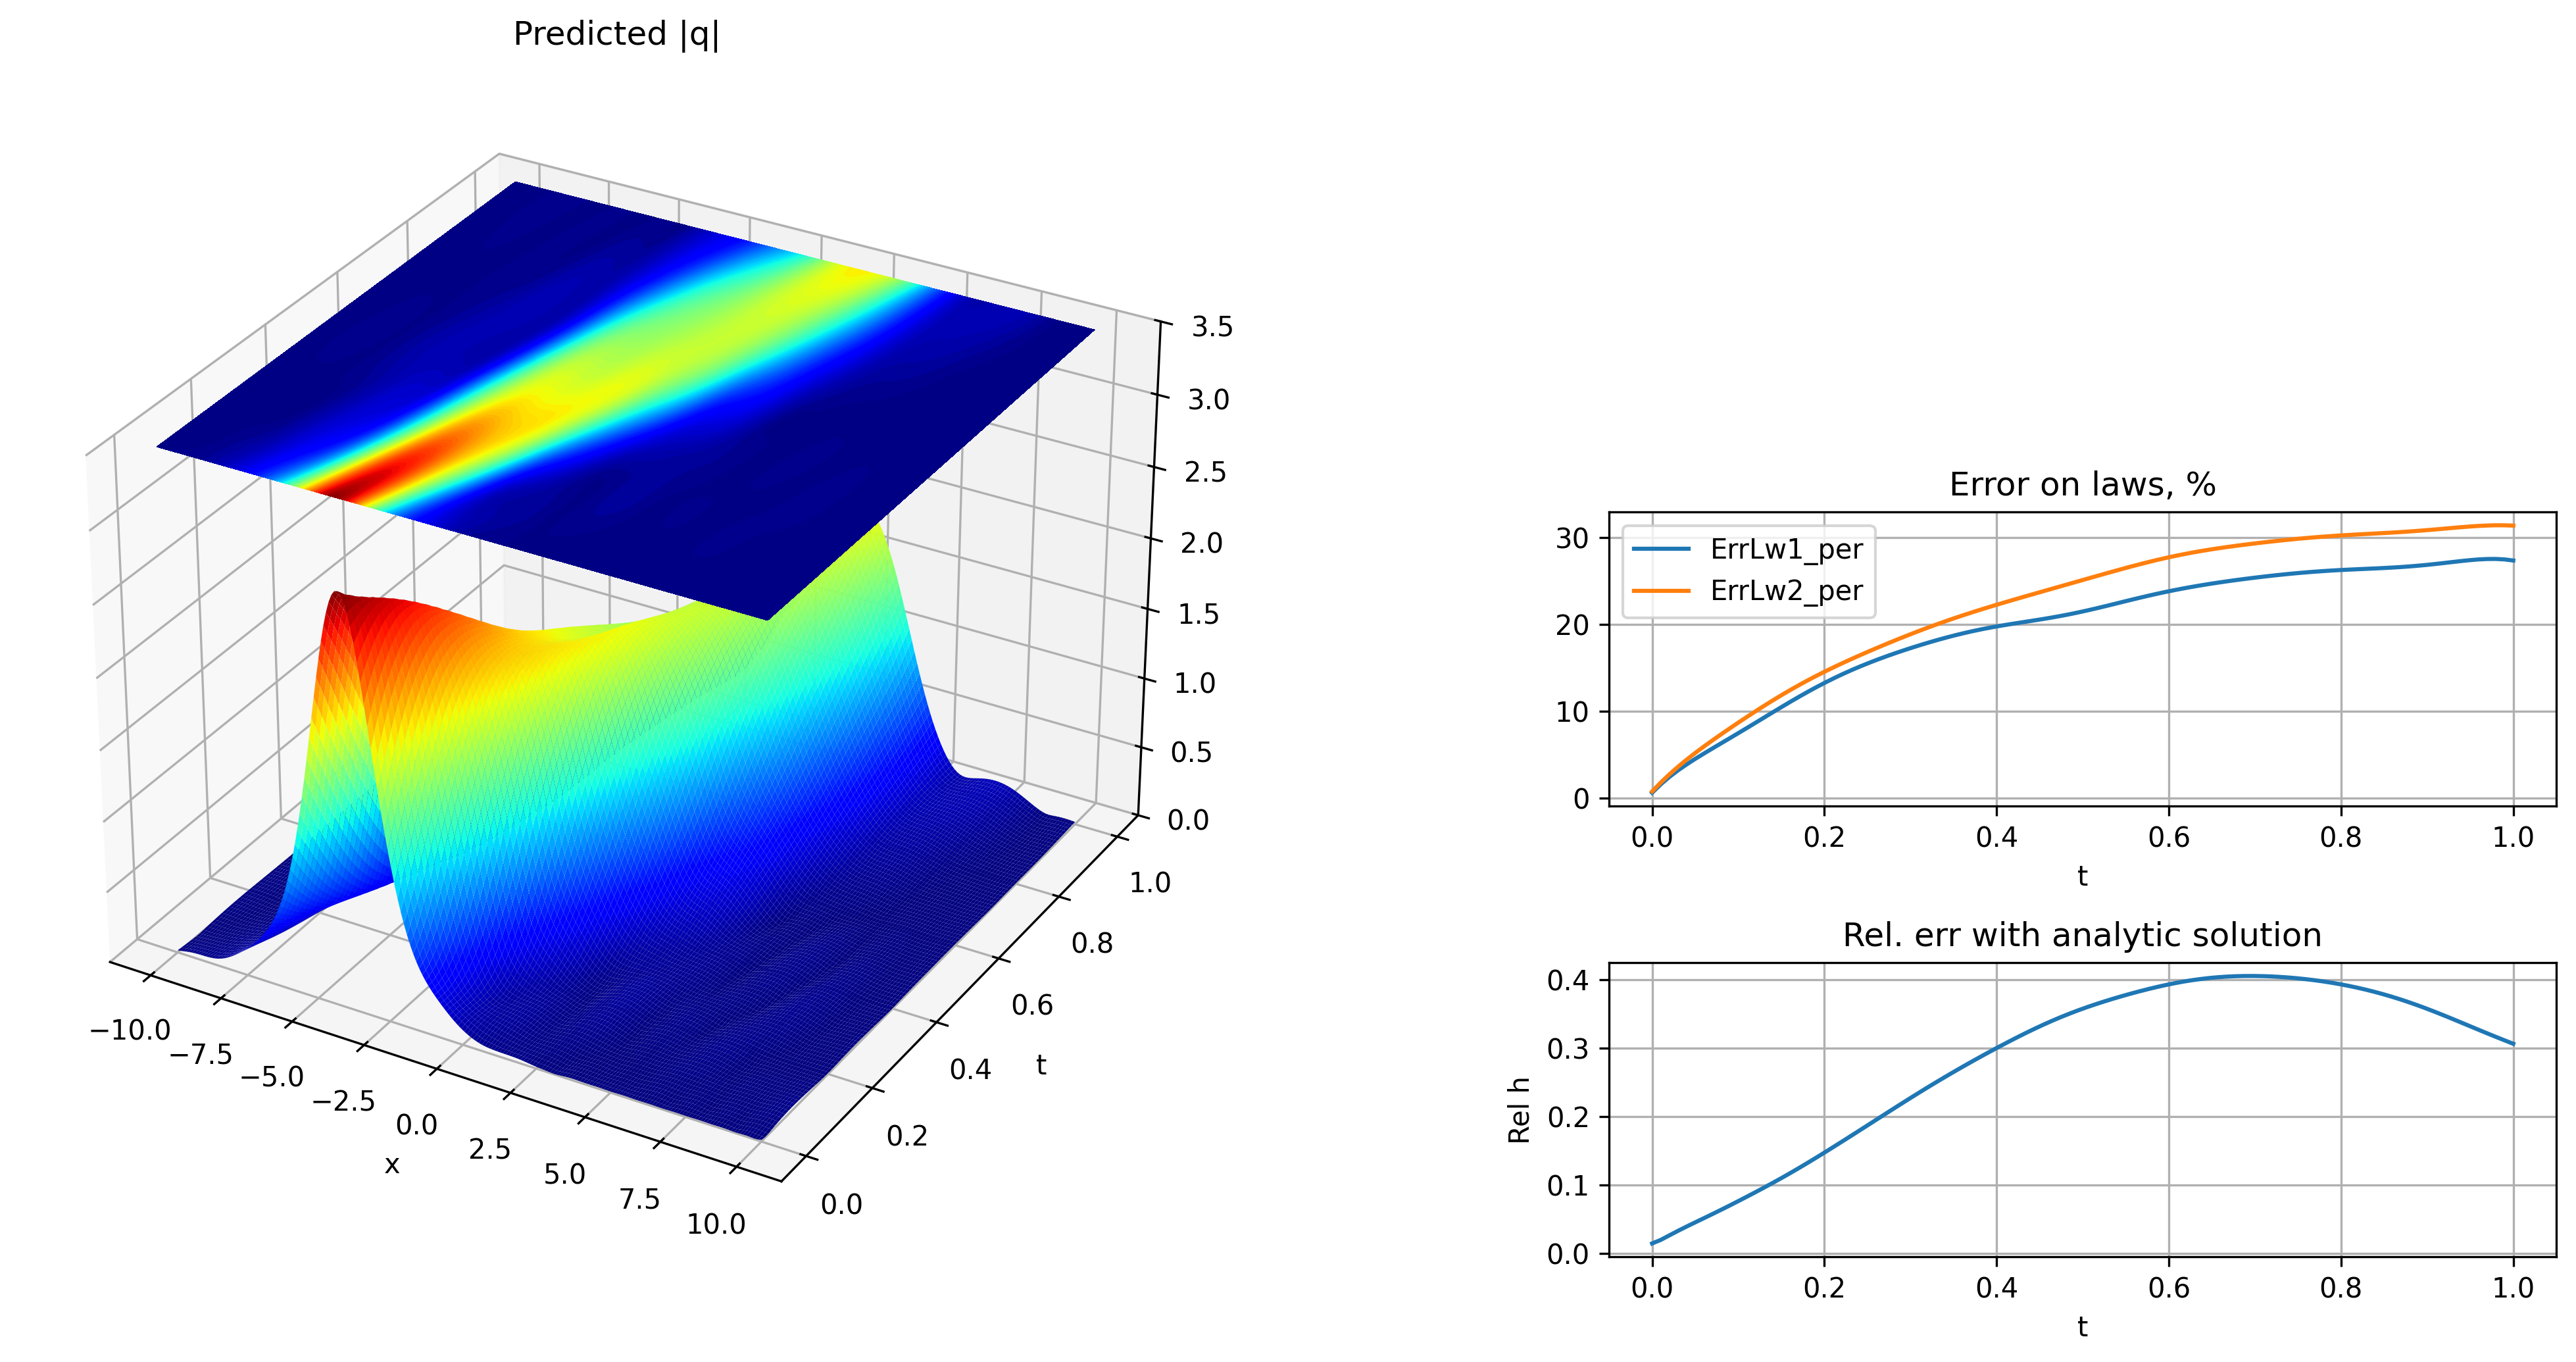

In [8]:
plot_errors(X, T, Q_pred, Q_truth, savefig=True, namefig="test_errors(6th_order).png", savetable=False, nametable="data(6th_order).csv")

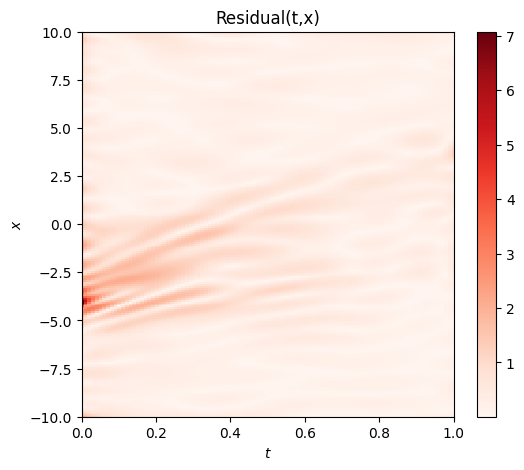

In [9]:
model.plot_residual(X, T)